In [1]:
import sys
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath("../"))  # importa dalla radice del progetto
from src import core
from src import pre_processing


In [2]:
data = core.import_data("/home/zampa/projects/ProMeteo/data/test_data.csv")
time_array = data.index
u = data["u"].to_numpy()

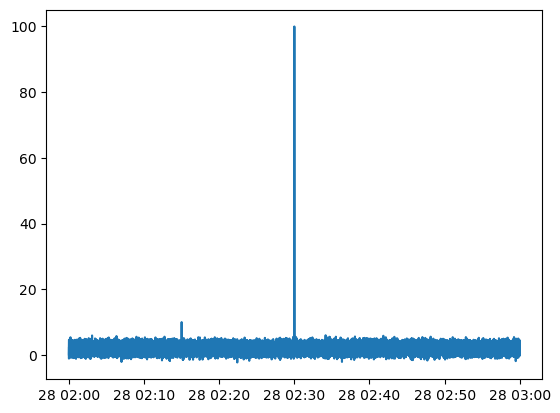

In [3]:
plt.plot(time_array, u)

In [4]:
u_cleaned, _ = pre_processing.remove_beyond_threshold(u, 30)

In [5]:
u_cleaned.shape

(72001,)

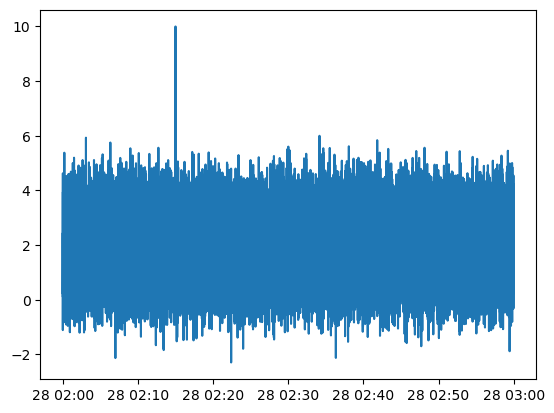

In [6]:
plt.plot(time_array, u_cleaned)

In [7]:
# valori oltre 30 effettivamente rimossi

In [8]:
# n_rows=15*60*20 # segnale a 20 Hz di durata 30 min
# array_example_1=np.random.normal(loc=2, scale=1, size=n_rows) # [m/s]
# array_example_2=np.random.normal(loc=4, scale=1, size=n_rows) # [m/s]
# array_example=np.concatenate([array_example_1, array_example_2])
# run_mean_ex, std_mean_ex = core.running_stats(array_example, 6001) # finestra di 5 min
# index=np.arange(0,len(array_example))
# plt.plot(index, array_example)
# plt.plot(index, run_mean_ex)


In [9]:
# prova di rotazioni
angoli = np.array([0,90,180,360,405,-45])
angoli_norm = angoli % 360
angoli_norm

array([  0,  90, 180,   0,  45, 315])

In [10]:
# prova di wind_dir in sistema LEC
u = [ 0, -1/np.sqrt(2), -1, -1/np.sqrt(2), 0,
    1/np.sqrt(2), 1,  1/np.sqrt(2)]
v = [-1, -1/np.sqrt(2),  0,  1/np.sqrt(2), 1, 
    1/np.sqrt(2), 0, -1/np.sqrt(2)]
wind_dir_expected = [0, 45, 90, 135, 180, 
                     225, 270, 315]
wind_dir = (np.degrees(np.arctan2(u, v)) + 180) % 360
np.testing.assert_equal(wind_dir, wind_dir_expected, err_msg="Something wrong")

In [16]:
u = [ 0, -1/np.sqrt(2), -1, -1/np.sqrt(2), 0,
    1/np.sqrt(2), 1,  1/np.sqrt(2)]
v = [-1, -1/np.sqrt(2),  0,  1/np.sqrt(2), 1, 
    1/np.sqrt(2), 0, -1/np.sqrt(2)]
w = np.full(len(u), 0)
wind = np.array([u,v,w])
wind
wind_rotated = pre_processing.rotation_to_LEC_reference(wind,
                                                        0,
                                                        "RM_YOUNG_81000")

In [17]:
wind_rotated

array([[ 0.        ,  0.70710678,  1.        ,  0.70710678,  0.        ,
        -0.70710678, -1.        , -0.70710678],
       [ 1.        ,  0.70710678,  0.        , -0.70710678, -1.        ,
        -0.70710678,  0.        ,  0.70710678],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

In [ ]:
u_base = [ 0, -1/np.sqrt(2), -1, -1/np.sqrt(2), 0,
        1/np.sqrt(2), 1,  1/np.sqrt(2)]
v_base = [-1, -1/np.sqrt(2),  0,  1/np.sqrt(2), 1, 
        1/np.sqrt(2), 0, -1/np.sqrt(2)]
w_base = [0, 0, 0, 0, 0,
            0, 0, 0]
length_single = 15 * 60

wind = np.array([np.repeat(u_base, length_single),
                    np.repeat(v_base, length_single),
                    np.repeat(w_base, length_single)])
wind_averaged = np.full(wind.shape, 0.0)
window_length = 5*60 + 1 # 5 min window, odd number of points
for i in range(3):
    wind_averaged[i,:],_ = core.running_stats(wind[i,:],window_length)

wind_rotated_result = pre_processing.rotation_to_streamline_reference(wind,
                                                                        wind_averaged)
v_rotated_result_averaged,_ = core.running_stats(wind_rotated_result[1,:],
                                                window_length)


In [ ]:

index_list_to_control = []
start_minutes = [5, 20, 35, 50, 65, 80, 95, 110]  # minuti di partenza

for start_min in start_minutes:
    start_idx = start_min * 60
    end_idx = (start_min + 5) * 60  # 5 minuti dopo
    index_list_to_control.append(np.arange(start_idx, end_idx + 1, 1))


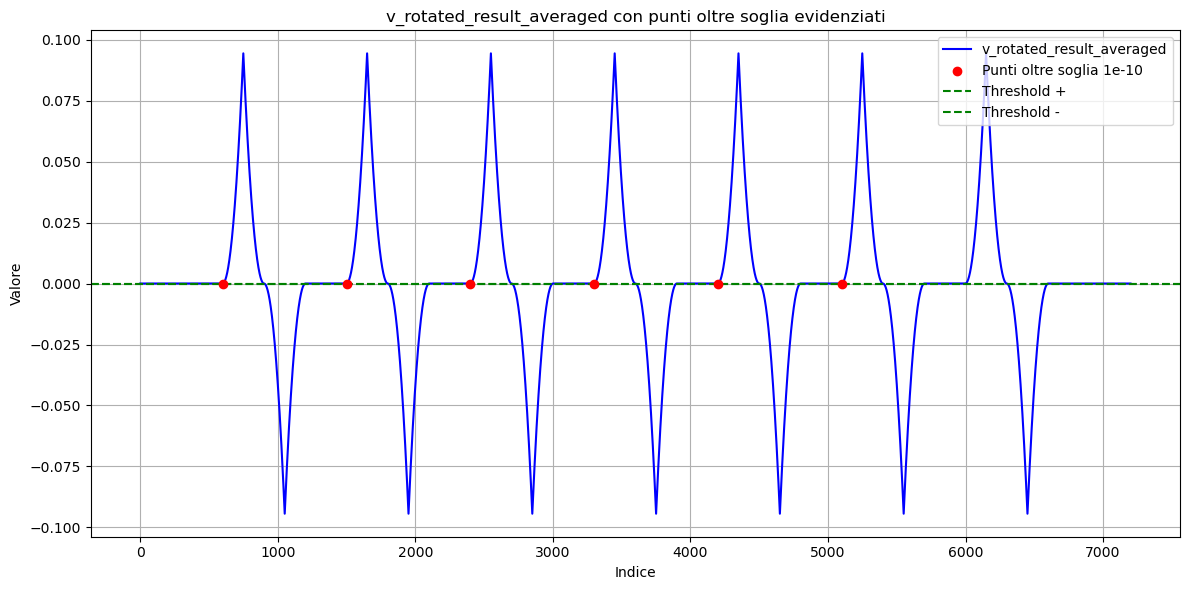

In [37]:
# Definiamo la soglia
threshold = 1e-10  # o qualsiasi altro valore tu voglia

# Mettiamo tutti gli indici da controllare in un unico array
indices_to_check = np.concatenate(index_list_to_control)

# Troviamo i punti che superano il threshold
mask_over_threshold = np.abs(v_rotated_result_averaged[indices_to_check]) > threshold

# Gli indici reali dei punti sopra soglia
bad_indices = indices_to_check[mask_over_threshold]
bad_values = v_rotated_result_averaged[bad_indices]

# ---- Plot ----
plt.figure(figsize=(12, 6))
plt.plot(v_rotated_result_averaged, label="v_rotated_result_averaged", color="blue")
plt.scatter(bad_indices, bad_values, color="red", label=f"Punti oltre soglia {threshold}", zorder=5)
plt.axhline(threshold, color="green", linestyle="--", label="Threshold +")
plt.axhline(-threshold, color="green", linestyle="--", label="Threshold -")

plt.title("v_rotated_result_averaged con punti oltre soglia evidenziati")
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# run_mean, std_mean = core.running_stats(u_cleaned, 6001)
u_despiked_VM97 = pre_processing.despiking_VM97(u_cleaned, 3.5, 6001, 3, 5, None)

Text(0.5, 1.0, 'Modified values: 32')

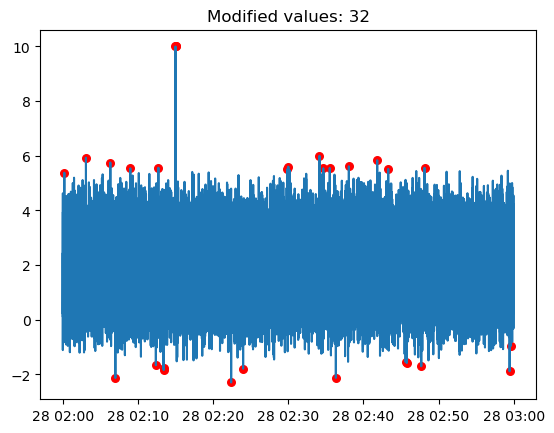

In [23]:
mask=u_cleaned != u_despiked_VM97
plt.plot(data.index, u_cleaned)
plt.scatter(time_array[mask], u_cleaned[mask], s=30, color='r')
plt.title(f"Modified values: {sum(mask)}")
# plt.xlim(pd.to_datetime("2012-09-28 02:10:00"),
#          pd.to_datetime("2012-09-28 02:20:00"))

In [26]:
u_despiked_robust, _ = pre_processing.despiking_robust(u_cleaned,
                                                    3.5,
                                                    6001)

Text(0.5, 1.0, 'Modified values: 49')

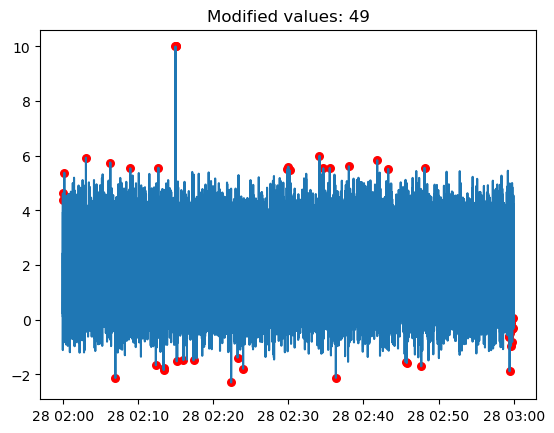

In [29]:
mask_robust = u_cleaned != u_despiked_robust
plt.plot(data.index, u_cleaned)
plt.scatter(time_array[mask_robust], u_cleaned[mask_robust], s=30, color='r')
plt.title(f"Modified values: {sum(mask_robust)}")